In [303]:
import os
import tensorflow as tf
import cv2 as cv

In [304]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [305]:
CONTENT_IMAGE_PATH = r'C:\Users\abdul\Desktop\CS 512 - Computer vision\Project\data\goat.png'
STYLE_IMAGE_PATH = r'C:\Users\abdul\Desktop\CS 512 - Computer vision\Project\data\muse.jpg'
CHANNELS = 3
HEIGHT = 300
WIDTH = 400
STYLE_WEIGHT = 1e-3
CONTENT_WEIGHT = 1e4
TOTAL_VARIATION_WEIGHT = 30

In [306]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [307]:
def read_image(file):
    img = plt.imread(file)
    if len(img.shape) == 2:
        # grayscale
        img = np.dstack((img,img,img))
    elif img.shape[2] == 4:
        # PNG with alpha channel
        img = img[:,:,:3]
    img = cv.resize(img, (WIDTH, HEIGHT))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

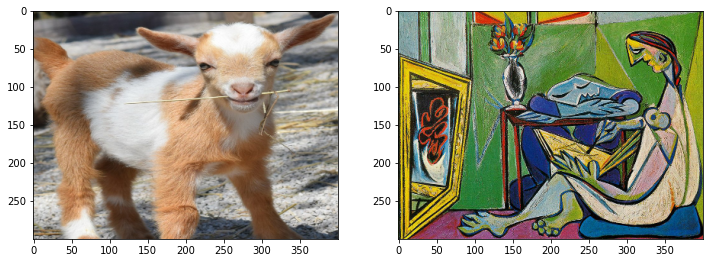

In [308]:
content_image = read_image(CONTENT_IMAGE_PATH)
style_image = read_image(STYLE_IMAGE_PATH)

plt.subplot(1, 2, 1)
plt.imshow(tf.squeeze(content_image))

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(style_image))

In [309]:
content_image.shape

TensorShape([1, 300, 400, 3])

In [310]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_38
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [311]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [312]:
def vgg_model(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg19.trainable = False

    outputs = [vgg19.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg19.input], outputs)
    return model

In [313]:
style_extractor = vgg_model(style_layers)
style_outputs = style_extractor(style_image*255)

In [314]:
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    
    return (gram / tf.cast(n, tf.float32))

In [315]:
def preprocess_image(img):
    new_img = tf.keras.applications.vgg19.preprocess_input(img)
    return new_img

In [316]:
class CustomModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(CustomModel, self).__init__()
        # custom vgg with specified layers as style and content layers
        self.vgg =  vgg_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # Expects float input in [0,1]
        inputs = inputs*255.0
        preprocessed_input = preprocess_image(inputs)
        # get layer outputs
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        # store outputs in dictionary
        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [317]:
extractor = CustomModel(style_layers, content_layers)

In [318]:
# run forward pass on style and content images
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [319]:
image = tf.Variable(content_image)

In [320]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [321]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [322]:
def compute_content_loss(targets, outputs):
    '''
    calculates the weighted content loss
    '''
    content_outputs = outputs['content']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= CONTENT_WEIGHT / num_content_layers
    
    return content_loss

In [323]:
def compute_style_loss(targets, outputs):
    '''
    calculates the weighted style loss
    '''
    style_outputs = outputs['style']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= STYLE_WEIGHT / num_style_layers
    
    return style_loss

In [324]:
def total_loss(outputs):
    style_loss = compute_style_loss(style_targets, outputs)
    content_loss = compute_content_loss(content_targets, outputs)
    total_loss = style_loss + content_loss
    total_loss += TOTAL_VARIATION_WEIGHT*tf.image.total_variation(image)
    
    return total_loss

In [325]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

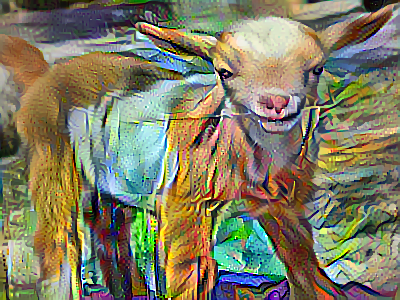

In [326]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))